In [1]:
from math import sin, cos

import numpy as np
import numpy.linalg as LA
import cvxpy as cp

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [2]:
"""Parameters"""
m = 0.9
l = 1.1
g = 9.81
b = 0.3

def control_law(t):
    return 1*np.sin(t)

def pendulum(t, y):
    # Unpack state
    theta, theta_d = y

    # Control law
    tau = control_law(t)
    
    dydt = np.zeros(2)
    dydt[0] = theta_d
    dydt[1] = ( tau - b * theta_d - m*g*l*sin(theta + 0.01*np.random.random()) ) / m/l**2
    
    return dydt

# Run simulation (solve ODE)
Ts     = 1/100
t_span = [0,20]
t_eval = np.arange(t_span[0], t_span[1], Ts)
x0 = np.array([np.deg2rad(0), 0])

sol = solve_ivp(pendulum, t_span, x0, t_eval=t_eval)

if sol.status != 0:
    print("Solve_ivp failed")
    
# Unpack log
t = sol.t
theta, theta_d = sol.y
theta_dd = np.gradient(theta_d, t)
tau = control_law(t)

## Parameter Estimation - (Unconstrained) least squares

Equations of motions are

$ \tau = \begin{bmatrix} \ddot\theta & \dot\theta & \sin(\theta) \end{bmatrix} \begin{bmatrix} ml^2 \\ b \\ mgl \end{bmatrix} $

$Y = AX$

$X = A^\dagger Y$

Parameters m=0.90, l=1.10, b=0.30
Estimate   m=0.94, l=1.04, b=0.33


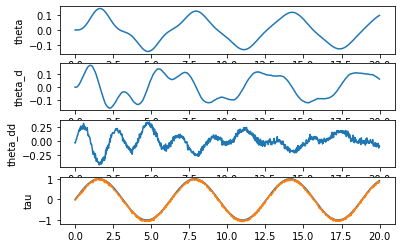

In [3]:
# Form A and Y matrices
A = np.stack([theta_dd, theta_d, np.sin(theta)], axis=1)
Y = tau.reshape(-1,1)

# print("A:", A.shape)
# print("Y:", Y.shape)

X_hat = LA.pinv(A) @ Y

# print(X_hat)

# Convert A_estimate to parameters
mll = X_hat[0,0]
b_hat = X_hat[1,0]
mgl = X_hat[2,0]

l_hat = mll / mgl * 9.81
m_hat = mgl / 9.81 / l_hat

print(f"Parameters m={m:.2f}, l={l:.2f}, b={b:.2f}")
print(f"Estimate   m={m_hat:.2f}, l={l_hat:.2f}, b={b_hat:.2f}")

# Reconstruct estimate
Y_hat = A @ X_hat

# Plot Results
_, ax = plt.subplots(4)
# Position
ax[0].plot(t, theta)
ax[0].set_ylabel('theta')

ax[1].plot(t, theta_d)
ax[1].set_ylabel('theta_d')

ax[2].plot(t, theta_dd)
ax[2].set_ylabel('theta_dd')

ax[3].plot(t, tau)
ax[3].plot(t, Y_hat)
ax[3].set_ylabel('tau')

plt.show()

## Parameter Estimation - Constrained least squares

Equations of motions are

$ \tau = \begin{bmatrix} \ddot\theta & \dot\theta & \sin(\theta) \end{bmatrix} \begin{bmatrix} ml^2 \\ b \\ mgl \end{bmatrix} $

Assumed that an unknown mass $m_2$ is added to the sytem

In [30]:
"""Parameters"""
m2 = np.random.random()
m = 0.9 + m2
l = 1.1
g = 9.81
b = 0.3

# Run simulation (solve ODE)
Ts     = 1/100
t_span = [0,20]
t_eval = np.arange(t_span[0], t_span[1], Ts)
x0 = np.array([np.deg2rad(0), 0])

sol = solve_ivp(pendulum, t_span, x0, t_eval=t_eval)

if sol.status != 0:
    print("Solve_ivp failed")
    
# Unpack log
t = sol.t
theta, theta_d = sol.y
theta_dd = np.gradient(theta_d, t)
tau = control_law(t)

### Incorporating known constraints

In [51]:
# Form A and Y matrices
A = np.stack([theta_dd, theta_d, np.sin(theta)], axis=1)
Y = tau.reshape(-1,1)

# print("A:", A.shape)
# print("Y:", Y.shape)

# Formulate convex optimisation problem
X = cp.Variable((3,1))
objective = cp.Minimize(cp.sum_squares(A @ X - Y))

# Set constraints
constraints = [
    X[0] >= 0,
    X[1] == 0.3,
    X[2] >= 0
]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print(X.value)

# Convert A_estimate to parameters
mll   = X.value[0,0]
mgl   = X.value[2,0]

l_hat = mll / mgl * 9.81
m_hat = mgl / 9.81 / l_hat

print(f"Parameters m={m:.2f}, l={l:.2f}")
print(f"Estimate   m={m_hat:.2f}, l={l_hat:.2f}")

[[ 1.05228576]
 [ 0.3       ]
 [10.01110178]]
Parameters m=0.94, l=1.10
Estimate   m=0.99, l=1.03


### Removing known variables

In [53]:
# Form A and Y matrices
A = np.stack([theta_dd, np.sin(theta)], axis=1)
Y = tau.reshape(-1,1)

# print("A:", A.shape)
# print("Y:", Y.shape)

# Formulate convex optimisation problem
X = cp.Variable((2,1))
objective = cp.Minimize(cp.sum_squares(A @ X - Y))

# Set constraints
constraints = [
    X[0] >= 0,
    X[1] >= 0
]

prob = cp.Problem(objective, constraints)
result = prob.solve()

print(X.value)

# Convert A_estimate to parameters
mll   = X.value[0,0]
mgl   = X.value[1,0]

l_hat = mll / mgl * 9.81
m_hat = mgl / 9.81 / l_hat

print(f"Parameters m={m:.2f}, l={l:.2f}")
print(f"Estimate   m={m_hat:.2f}, l={l_hat:.2f}")

[[ 1.0626605 ]
 [10.03429827]]
Parameters m=0.94, l=1.10
Estimate   m=0.98, l=1.04
